In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import READ_EDAB_Utilities_py as reupy
from scipy.interpolate import RegularGridInterpolator

In [3]:
#url = 'http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/forecast/tob_forecast_i199303.nc'
#forecast_test = xr.open_dataset(url)

In [109]:
glbt

<xarray.Dataset>
Dimensions:    (latitude: 217, longitude: 241, time: 342)
Coordinates:
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-06-01
Data variables:
    bottomT    (time, latitude, longitude) float32 ...

In [11]:
glbt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_glorys_M.nc')

In [13]:
mom6bt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_monthly.199301-201912.tob.nc')

In [10]:
static = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_static_deptho.nc')

In [14]:
gl_regrid = np.empty([342, 774, 844])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(mom6bt.lat.values, mom6bt.lon.values-360)
for i in range(342):
    interp_to_mom6 = RegularGridInterpolator((glbt.latitude.values, glbt.longitude.values), glbt.bottomT[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))


In [15]:
bt_gl = xr.Dataset(data_vars = {'tob': (['time','lon','lat'], gl_regrid)},
                          coords = {'time': glbt.time,
                                    'lat': mom6bt.lat,
                                    'lon': mom6bt.lon})

In [16]:
#subset to the SNE+MAB
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')
mab = epu[epu.EPU == 'MAB']
mab_m6 = reupy.crop_nd(mom6bt, 'lon', 'lat', mab)
mab_gl = reupy.crop_nd(bt_gl, 'lon', 'lat', mab)

In [34]:
#remove everything,200m
mab_m6_200 = mab_m6.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
mab_gl_200 = mab_gl.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))

In [116]:
#remove everything except june-sept
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_m6_200_jjas = mab_m6_200.sel(time=is_jjas(mab_m6_200['time.month']))
mab_gl_200_jjas = mab_gl_200.sel(time=is_jjas(mab_gl_200['time.month']))

In [117]:
#calculate june-sept climatetological temp at each gridcell
clim_m6 = mab_m6_200_jjas.mean('time')
clim_gl = mab_gl_200_jjas.mean('time')

In [118]:
# remove everything that is greater than 10C

clim_10_m6 = clim_m6.where(clim_m6.tob <=10)
clim_10_gl = clim_gl.where(clim_gl.tob <=10)

mab_m6_200_jjas_10 = mab_m6_200_jjas.where(clim_m6.tob <=10)
mab_gl_200_jjas_10 = mab_gl_200_jjas.where(clim_gl.tob <= 10)

$$ Model\, CPI_y =\frac{ \sum_{i=1}^{n} {(T_{i,y} - \bar{T}_{i,\, 1972-2019})}} {n} $$



In [119]:
# Here we just use the time domain of the model 1993-2019 for Tbar

top_of_fraction_test = mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6

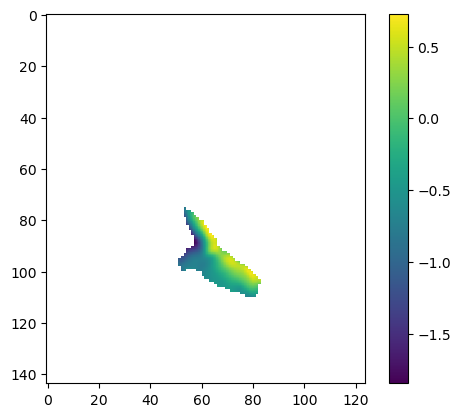

In [120]:
plt.imshow(top_of_fraction_test.tob[10,:,:])
plt.colorbar()

In [121]:
M_CPIy_m6 = (mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_m6.tob) == False)[0])

M_CPIy_gl = (mab_gl_200_jjas_10.groupby('time.year').mean('time') - clim_10_gl).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_gl.tob) == False)[0])


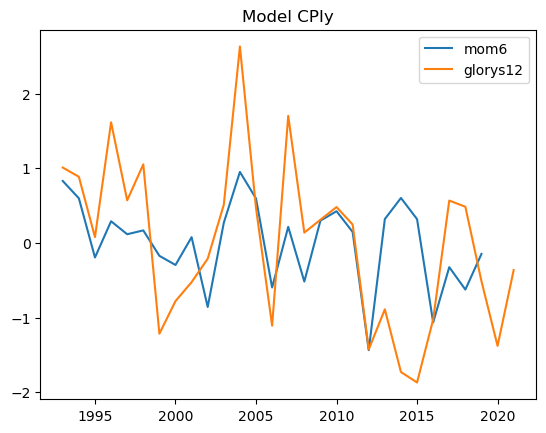

In [122]:
plt.plot(M_CPIy_m6.year, M_CPIy_m6.tob*-1, label = 'mom6')
plt.plot(M_CPIy_gl.year, M_CPIy_gl.tob*-1, label = 'glorys12')
plt.title('Model CPIy', fontsize = 12)
plt.legend()

$$ Model\, PI_y =\frac{ \sum_{i=1}^{n} {(Month_{i,y} - \bar{Month}_{i,\, 1972-2019})}} {n} $$


In [123]:
mab_m6_200_10 = mab_m6_200.where(clim_m6.tob <=10)
mab_gl_200_10 = mab_gl_200.where(clim_m6.tob <=10)

In [124]:
def is_jjaso(month):
    return (month >= 6) & (month <= 10)

mab_m6_200_10_jjaso = mab_m6_200_10.sel(time=is_jjaso(mab_m6_200_10['time.month']))
mab_gl_200_10_jjaso = mab_gl_200_10.sel(time=is_jjaso(mab_gl_200_10['time.month']))

In [125]:
# if the temperature never gets below 10C in one year that can be nan

years = np.arange(1993,2020)
day_yr = np.empty([len(years),144,124])
day_yr[:,:,:] = np.nan
j=0
for yr in years:
    year_subset = mab_m6_200_10_jjaso.sel(time= mab_m6_200_10_jjaso['time.year'] == yr)
    yr_mo = np.empty([144,124])
    yr_mo[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo[np.where(year_subset.tob[k,:,:] > 10)] = k+6
    day_yr[j,:,:] = yr_mo
    j = j+1

years = np.arange(1993,2021)
day_yr_gl = np.empty([len(years),144,124])
day_yr_gl[:,:,:] = np.nan
j=0
for yr in years:
    year_subset_gl = mab_gl_200_10_jjaso.sel(time= mab_gl_200_10_jjaso['time.year'] == yr)
    yr_mo_gl = np.empty([144,124])
    yr_mo_gl[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo_gl[np.where(year_subset_gl.tob[k,:,:] > 10)] = k+6
    day_yr_gl[j,:,:] = yr_mo_gl
    j = j+1

In [126]:
clim_day = np.nanmean(day_yr, 0)

clim_day_gl = np.nanmean(day_yr_gl, 0)

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_8696\3955709937.py:1: RuntimeWarning: Mean of empty slice
  clim_day = np.nanmean(day_yr, 0)
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_8696\3955709937.py:3: RuntimeWarning: Mean of empty slice
  clim_day_gl = np.nanmean(day_yr_gl, 0)


In [127]:
day_yr_ds = xr.Dataset(data_vars={'month': (['year', 'lat','lon'], day_yr)},
           coords = {'year': np.arange(1993,2020),
                     'lat': mab_m6_200_10_jjaso.lat,
                     'lon': mab_m6_200_10_jjaso.lon})

In [128]:
day_yr_gl_ds = xr.Dataset(data_vars={'month': (['year', 'lat','lon'], day_yr_gl)},
           coords = {'year': np.arange(1993,2021),
                     'lat': mab_gl_200_10_jjaso.lat,
                     'lon': mab_gl_200_10_jjaso.lon})

In [129]:
day_yr_clim = xr.Dataset(data_vars = {'month': (['lat','lon'], clim_day)},
                         coords = {'lat': mab_m6_200_10_jjaso.lat,
                                   'lon': mab_m6_200_10_jjaso.lon})

In [130]:
day_yr_gl_clim = xr.Dataset(data_vars = {'month': (['lat','lon'], clim_day_gl)},
                         coords = {'lat': mab_gl_200_10_jjaso.lat,
                                   'lon': mab_gl_200_10_jjaso.lon})

In [131]:
model_piy_m6 = ((day_yr_ds - day_yr_clim).sum(['lat','lon']))/len(np.where(np.isnan(day_yr_clim.month) == False)[0])

In [132]:
model_piy_gl = ((day_yr_gl_ds - day_yr_gl_clim).sum(['lat','lon']))/len(np.where(np.isnan(day_yr_gl_clim.month) == False)[0])

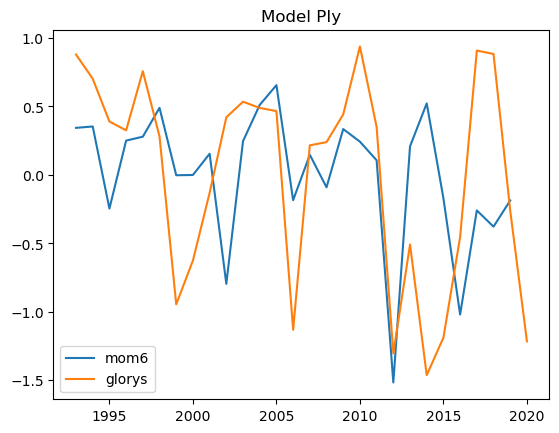

In [133]:
plt.plot(model_piy_m6.year, model_piy_m6.month, label = 'mom6')
plt.plot(model_piy_gl.year, model_piy_gl.month, label = 'glorys')
plt.title('Model PIy', fontsize = 12)
plt.legend()

$$ Model\, SEI = n\ cells <10C\ for\ 2\ months\ + $$

In [134]:
mab_m6_200_jjas_10

<xarray.Dataset>
Dimensions:  (time: 108, lat: 144, lon: 124)
Coordinates:
  * lon      (lon) float64 282.0 282.1 282.2 282.3 ... 291.7 291.8 291.9 292.0
  * lat      (lat) float64 34.01 34.07 34.13 34.19 ... 42.79 42.85 42.92 42.98
  * time     (time) datetime64[ns] 1993-06-16 1993-07-16T12:00:00 ... 2019-09-16
Data variables:
    tob      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    NumFilesInSet:       1
    title:               NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    history:             Derived and written at NOAA Physical Science Laboratory
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    contact:             chia-wei.hsu@noaa.gov
    dataset:             regional mom6 regrid

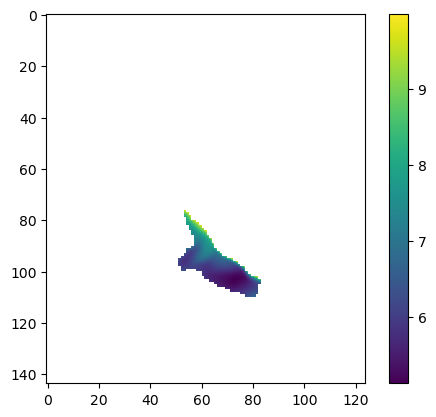

In [165]:
plt.imshow(mab_m6_200_jjas_10.tob[:4,:,:].where(mab_m6_200_jjas_10.tob[:4,:,:]<10)[0,:,:])
plt.colorbar()


In [170]:
test_size_index = mab_m6_200_jjas_10.tob[:4,:,:].data

In [176]:
test_size_index[np.where(test_size_index<10)] = 1
test_size_index[np.where(test_size_index>=10)] = 0

In [183]:
test_diff = np.diff(test_size_index, axis =0)

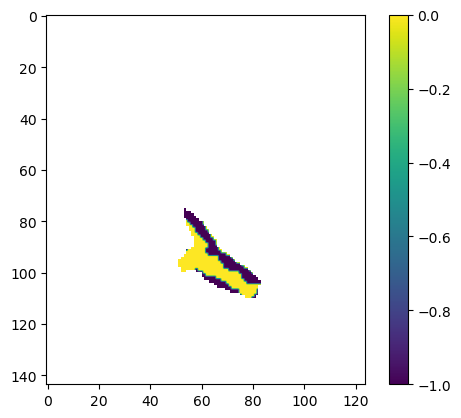

In [187]:
plt.imshow(test_diff[2,:,:])
plt.colorbar()

In [194]:
len(np.where(test_diff == 0)[1])

1288

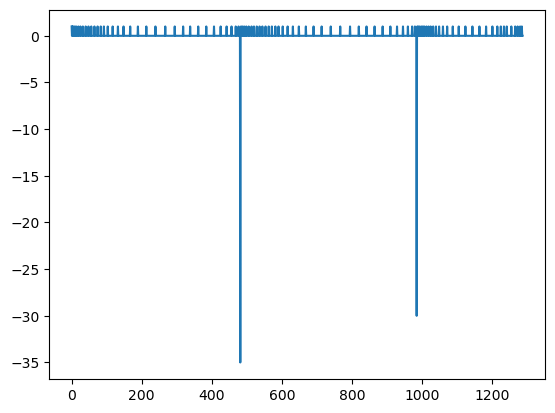

In [198]:
plt.plot(np.diff(np.where(test_diff == 0)[1]))

In [203]:
len(np.where(np.diff(np.where(test_diff == 0)[1])!=0)[0])

102

In [208]:
years = np.arange(1993,2020)

sei_m6 = [0]
for yr in years:
    year_subset_m6 = mab_m6_200_jjas_10.tob.sel(time= mab_m6_200_jjas_10['time.year'] == yr).data
    year_subset_m6[np.where(year_subset_m6<10)] = 1
    year_subset_m6[np.where(year_subset_m6>=10)] = 0
    year_subset_diff_m6 = np.diff(year_subset_m6, axis =0)
    sei_n_m6 = len(np.where(np.diff(np.where(year_subset_diff_m6 == 0)[1])!=0)[0])
    sei_m6 = np.append(sei_m6,sei_n_m6)
sei_m6=sei_m6[1:]

In [209]:
years = np.arange(1993,2021)

sei_gl = [0]
for yr in years:
    year_subset_gl = mab_gl_200_jjas_10.tob.sel(time= mab_gl_200_jjas_10['time.year'] == yr).data
    year_subset_gl[np.where(year_subset_gl<10)] = 1
    year_subset_gl[np.where(year_subset_gl>=10)] = 0
    year_subset_diff_gl = np.diff(year_subset_gl, axis =0)
    sei_n_gl = len(np.where(np.diff(np.where(year_subset_diff_gl == 0)[1])!=0)[0])
    sei_gl = np.append(sei_gl,sei_n_gl)
sei_gl=sei_gl[1:]

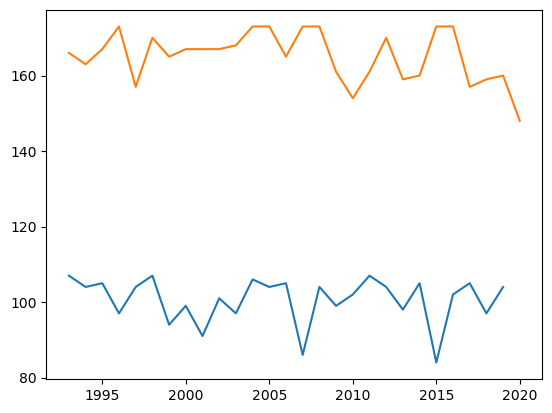

In [210]:
plt.plot(np.arange(1993,2020), sei_m6)
plt.plot(np.arange(1993,2021), sei_gl)

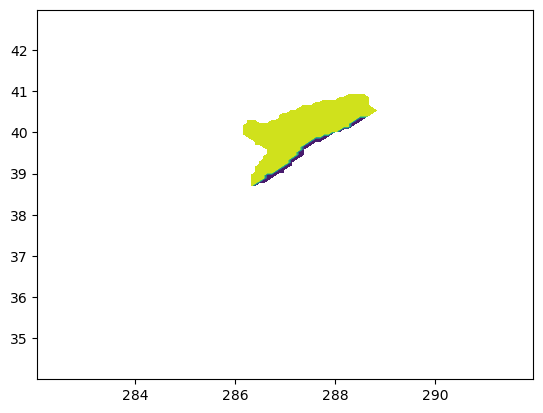

In [222]:
plt.contourf(mab_m6_200_jjas_10.lon, mab_m6_200_jjas_10.lat, mab_m6_200_jjas_10.tob[0,:,:], levels = [)

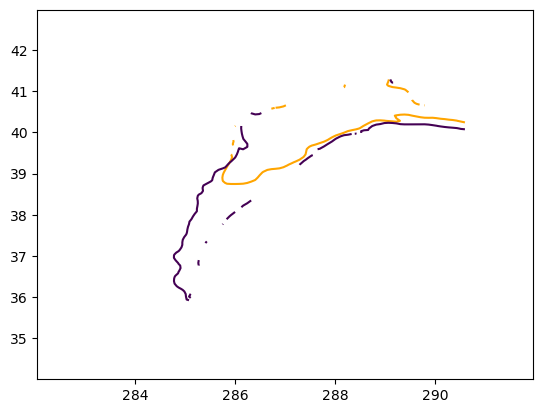

In [255]:
plt.contour(mab_m6_200.lon, mab_m6_200.lat, mab_m6_200.tob[5+36,:,:], levels = [10],colors = 'orange')
plt.contour(mab_gl_200.lon, mab_gl_200.lat, mab_gl_200.tob[5+36,:,:].T, levels = [10])

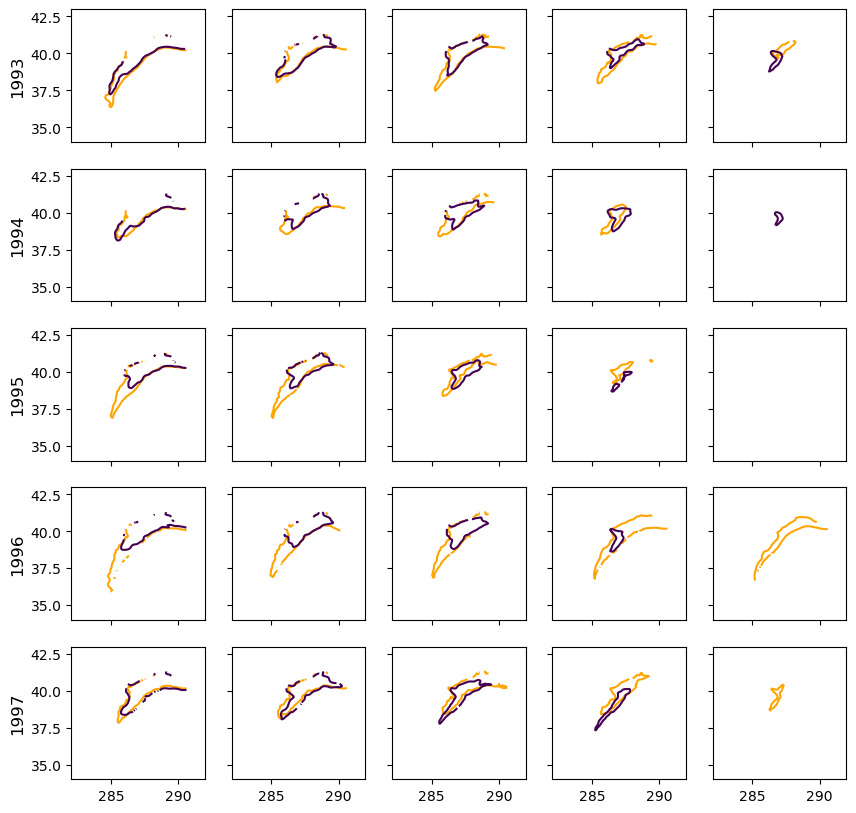

In [269]:
years = np.arange(1993,2020)
row_num = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
col_num = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

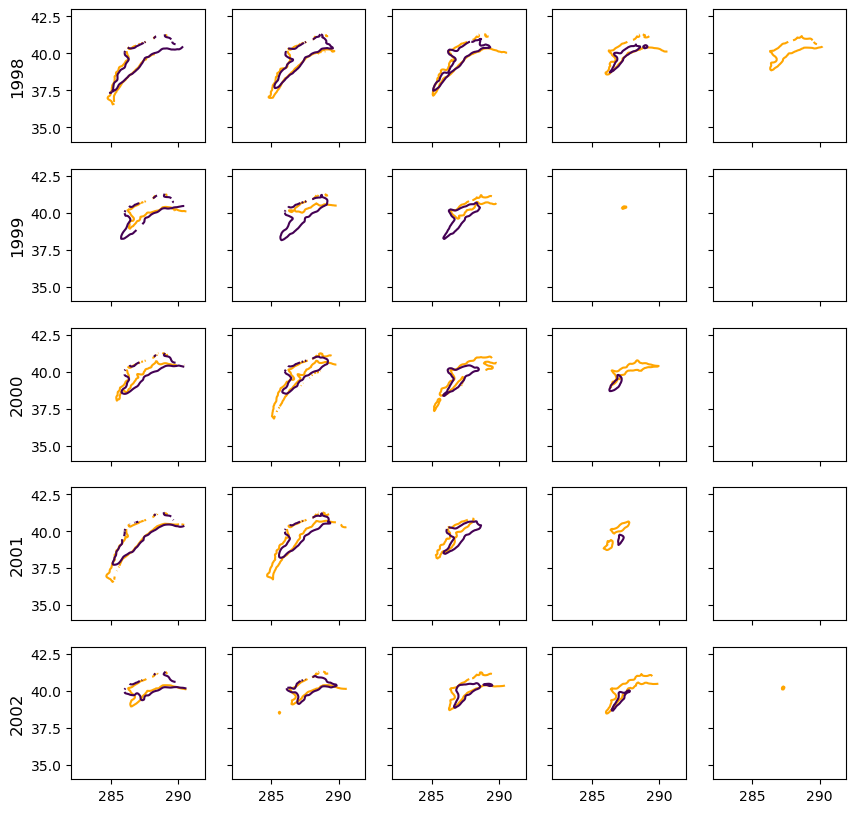

In [270]:

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+5]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

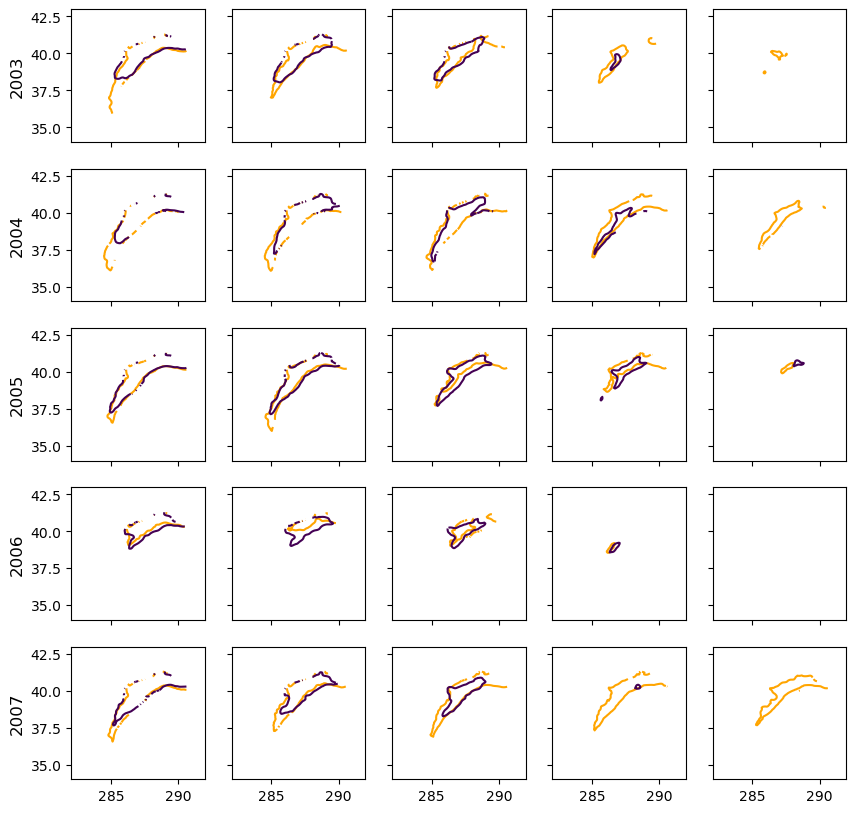

In [271]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+10]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

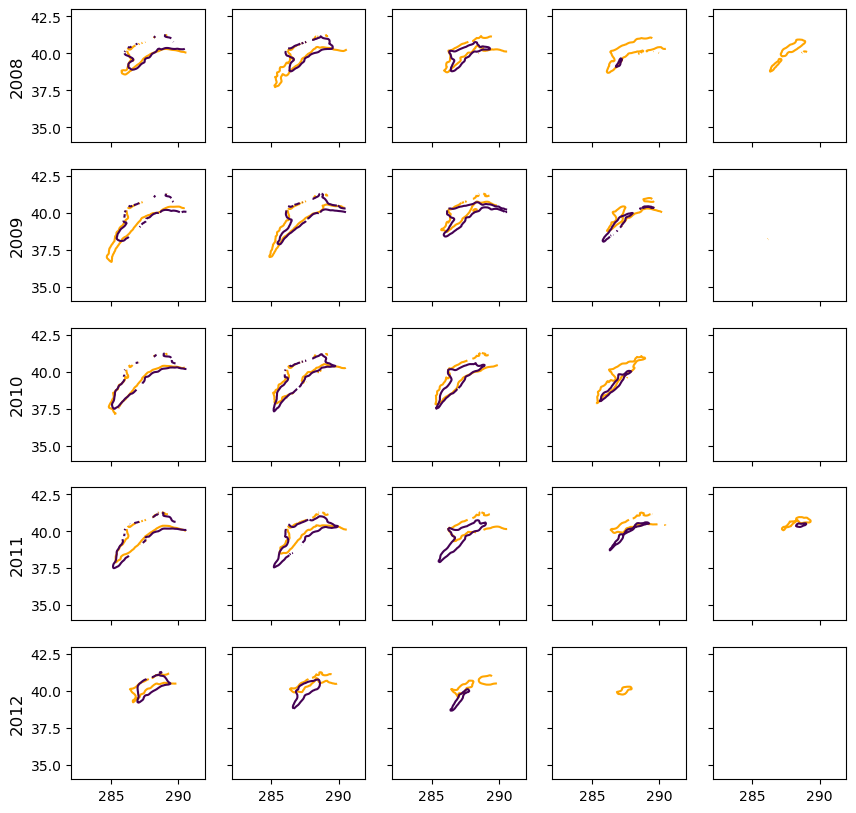

In [272]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+15]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

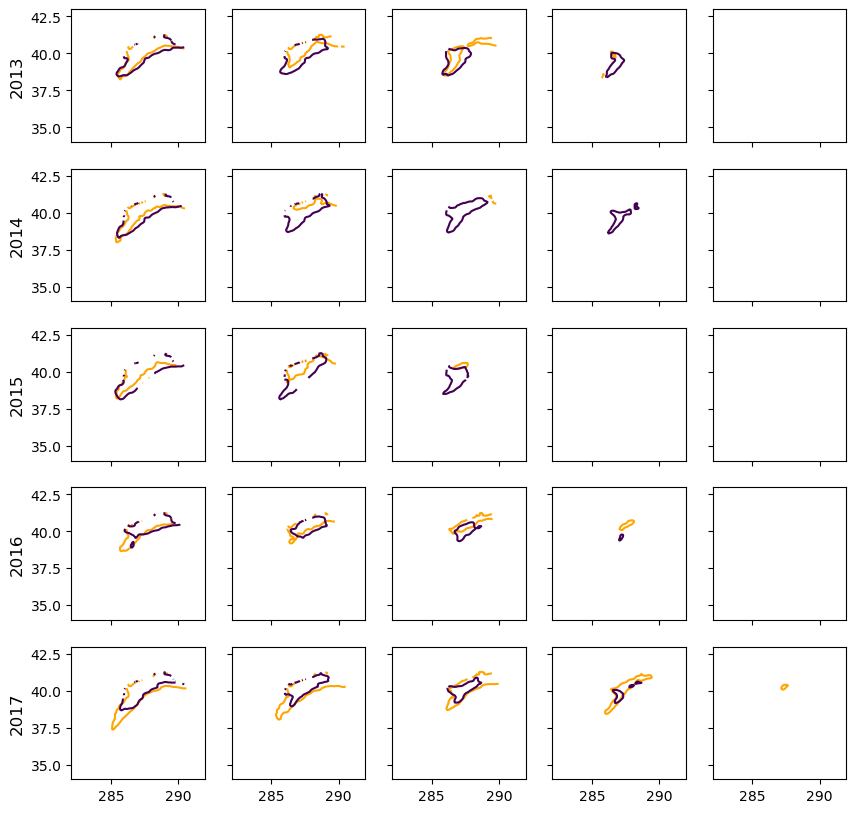

In [273]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+20]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

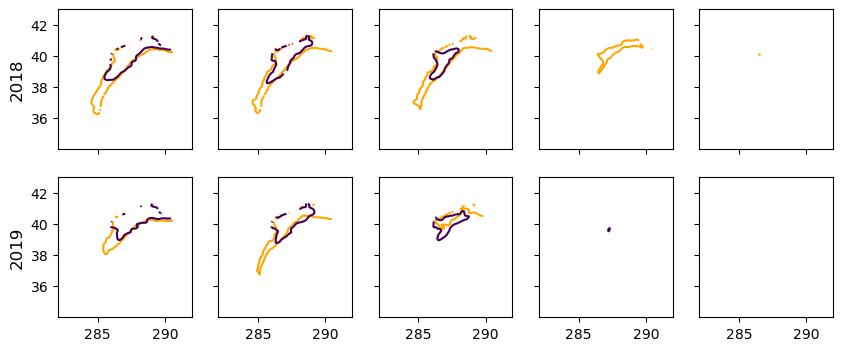

In [276]:
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = [10,4], sharex = True, sharey = True)

for i in range(2):
    yr= years[i+25]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

# Forecasted Cold Pool
March and June initializations for JJAS of 2015, 2016, 2017, 2018, 2019

In [5]:
tob_march_2015 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201503.nc')
tob_march_2016 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201603.nc')
tob_march_2017 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201703.nc')
tob_march_2018 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201803.nc')
tob_march_2019 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201903.nc')

tob_june_2015 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201506.nc')
tob_june_2016 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201606.nc')
tob_june_2017 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201706.nc')
tob_june_2018 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201806.nc')
tob_june_2019 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201906.nc')

In [19]:
tob_march_2015_mab = reupy.crop_nd(tob_march_2015, 'lon','lat',mab)
tob_march_2016_mab = reupy.crop_nd(tob_march_2016, 'lon','lat',mab)
tob_march_2017_mab = reupy.crop_nd(tob_march_2017, 'lon','lat',mab)
tob_march_2018_mab = reupy.crop_nd(tob_march_2018, 'lon','lat',mab)
tob_march_2019_mab = reupy.crop_nd(tob_march_2019, 'lon','lat',mab)

tob_june_2015_mab = reupy.crop_nd(tob_june_2015, 'lon','lat',mab)
tob_june_2016_mab = reupy.crop_nd(tob_june_2016, 'lon','lat',mab)
tob_june_2017_mab = reupy.crop_nd(tob_june_2017, 'lon','lat',mab)
tob_june_2018_mab = reupy.crop_nd(tob_june_2018, 'lon','lat',mab)
tob_june_2019_mab = reupy.crop_nd(tob_june_2019, 'lon','lat',mab)

In [20]:
#remove everything,200m
tob_march_2015_mab_200 = tob_march_2015_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2016_mab_200 = tob_march_2016_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2017_mab_200 = tob_march_2017_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2018_mab_200 = tob_march_2018_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2019_mab_200 = tob_march_2019_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))

tob_june_2015_mab_200 = tob_june_2015_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2016_mab_200 = tob_june_2016_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2017_mab_200 = tob_june_2017_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2018_mab_200 = tob_june_2018_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2019_mab_200 = tob_june_2019_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))


In [23]:
tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(0,0))

<xarray.DataArray 'tob' (lead: 1, lat: 144, lon: 124)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    init     datetime64[ns] 2015-03-01
  * lead     (lead) int32 0
    month    int32 3
  * lon      (lon) float64 282.0 282.1 282.2 282.3 ... 291.7 291.8 291.9 292.0
  * lat      (lat) float64 34.01 34.07 34.13 34.19 ... 42.79 42.85 42.92 42.98

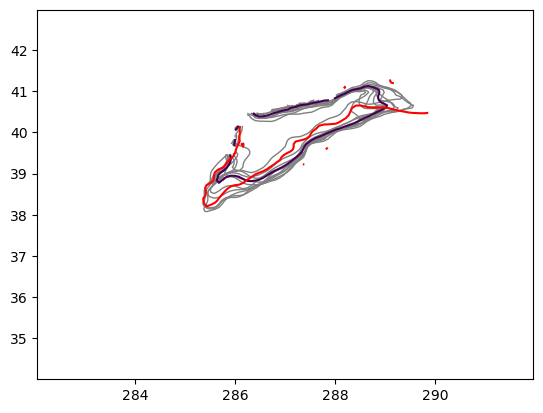

In [51]:
plt.contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat, np.squeeze(tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(5,5))), levels = [10])
for i in tob_march_2015_mab_200.member:
    plt.contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat ,np.squeeze(tob_march_2015_mab_200.tob.sel(member = slice(i,i), lead = slice(5,5))), levels = [10], linewidths = 1, colors = 'grey', zorder = 0)
plt.contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice('2015-06-01', '2015-06-01')).tob).T, colors = 'red',levels = [10])

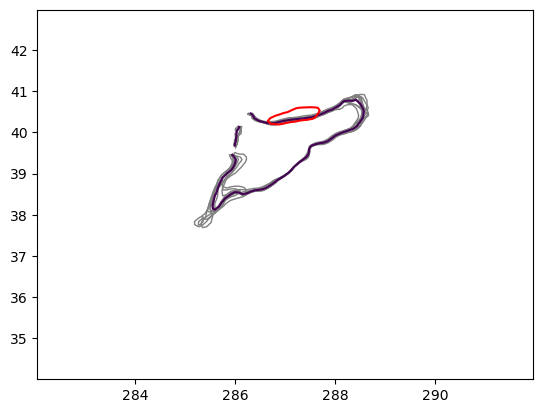

In [58]:
plt.contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat, np.squeeze(tob_june_2015_mab_200.tob.mean('member').sel(lead = slice(2,2))), levels = [10])
for i in tob_june_2015_mab_200.member:
    plt.contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat ,np.squeeze(tob_june_2015_mab_200.tob.sel(member = slice(i,i), lead = slice(2,2))), levels = [10], linewidths = 1, colors = 'grey', zorder = 0)
plt.contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice('2015-08-01', '2015-08-01')).tob).T, colors = 'red',levels = [10])

In [83]:
mab_m6_200.time

<xarray.DataArray 'time' (time: 324)>
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', ..., '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  GREGORIAN
    bounds:         time_bnds
    cell_methods:   time: mean

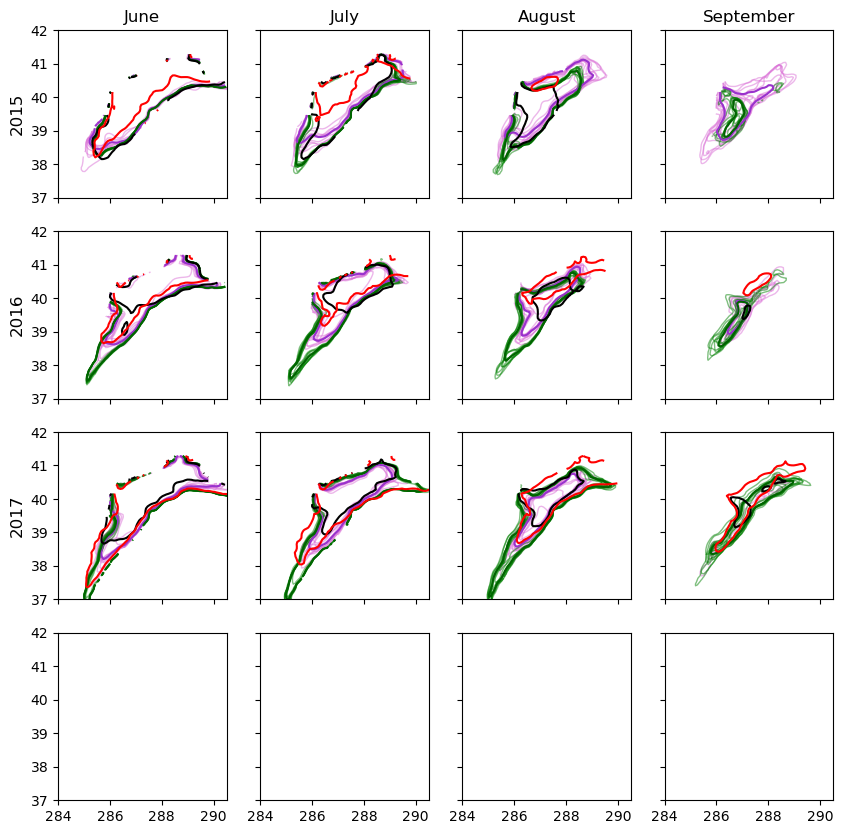

In [86]:
fig,ax = plt.subplots(nrows = 4, ncols = 4, figsize = [10,10], sharex = True, sharey = True)

year_2015 = ['2015-06-01','2015-07-01','2015-08-01','2015-09-01']
year_2015m6 = ['2015-06-16','2015-07-16','2015-08-16','2015-09-16']
year_2016 = ['2016-06-01','2016-07-01','2016-08-01','2016-09-01']
year_2016m6 = ['2016-06-16','2016-07-16','2016-08-16','2016-09-16']
year_2017 = ['2017-06-01','2017-07-01','2017-08-01','2017-09-01']
year_2017m6 = ['2017-06-16','2017-07-16','2017-08-16','2017-09-16']

month = ['June','July','August','September']
for i in range(4):
    ax[0,i].set_ylim([37,42])
    ax[0,i].set_xlim([284, 290.5])
    ax[0,i].contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat, np.squeeze(tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2015_mab_200.member:
        ax[0,i].contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat ,np.squeeze(tob_march_2015_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[0,i].contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat, np.squeeze(tob_june_2015_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2015_mab_200.member:
        ax[0,i].contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat ,np.squeeze(tob_june_2015_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)
    
    ax[0,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2015m6[i], year_2015m6[i])).tob), colors = 'k',levels = [10])
    ax[0,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2015[i], year_2015[i])).tob).T, colors = 'red',levels = [10])
    ax[0,i].set_title(month[i])
                        
    ax[0,0].set_ylabel('2015', fontsize = 12)

for i in range(4):
    ax[1,i].set_ylim([37,42])
    ax[1,i].set_xlim([284, 290.5])
    ax[1,i].contour(tob_march_2016_mab_200.lon, tob_march_2016_mab_200.lat, np.squeeze(tob_march_2016_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2016_mab_200.member:
        ax[1,i].contour(tob_march_2016_mab_200.lon, tob_march_2016_mab_200.lat ,np.squeeze(tob_march_2016_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[1,i].contour(tob_june_2016_mab_200.lon, tob_june_2016_mab_200.lat, np.squeeze(tob_june_2016_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2016_mab_200.member:
        ax[1,i].contour(tob_june_2016_mab_200.lon, tob_june_2016_mab_200.lat ,np.squeeze(tob_june_2016_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)
    
    ax[1,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2016m6[i], year_2016m6[i])).tob), colors = 'k',levels = [10])
    ax[1,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2016[i], year_2016[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[1,0].set_ylabel('2016', fontsize = 12)

for i in range(4):
    ax[2,i].set_ylim([37,42])
    ax[2,i].set_xlim([284, 290.5])
    ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat, np.squeeze(tob_march_2017_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2017_mab_200.member:
        ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat ,np.squeeze(tob_march_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat, np.squeeze(tob_june_2017_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2017_mab_200.member:
        ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat ,np.squeeze(tob_june_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)

    ax[2,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2017m6[i], year_2017m6[i])).tob), colors = 'k',levels = [10])
    ax[2,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2017[i], year_2017[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[2,0].set_ylabel('2017', fontsize = 12)

for i in range(4):
    ax[2,i].set_ylim([37,42])
    ax[2,i].set_xlim([284, 290.5])
    ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat, np.squeeze(tob_march_2017_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2017_mab_200.member:
        ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat ,np.squeeze(tob_march_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat, np.squeeze(tob_june_2017_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2017_mab_200.member:
        ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat ,np.squeeze(tob_june_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)

    ax[2,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2017m6[i], year_2017m6[i])).tob), colors = 'k',levels = [10])
    ax[2,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2017[i], year_2017[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[2,0].set_ylabel('2017', fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+15]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)